In [1]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
# Importing dependencies

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

Using TensorFlow backend.


In [3]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=15,  verbose=1, mode='min')
callbacks_list = [earlystop]

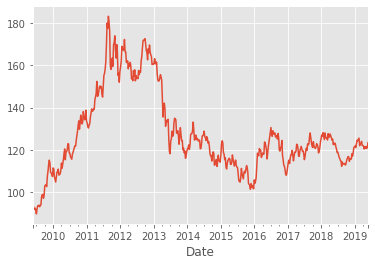

In [4]:
# Loading the dataset

df = pd.read_csv('Asset_Dataset/GLD_10y.csv',parse_dates = True , index_col = 0)
df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot()

In [5]:
print("Correlation =",df['Close'].corr(df['Adj Close'])) # to check if the stocks are splitted or not in the past

Correlation = 0.9999999999999998


Since the Adj. Close and Close columns are highly correlated, we do not need to think about splittting the series.

In [6]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(1,input_shape = (X_train.shape[1],1),return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr=lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val),
                        verbose = 0, shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [7]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mse, rmse, r2, Y_test, Y_hat
  

In [8]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Univariate-LSTM")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [9]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

## Model Building

(522,)


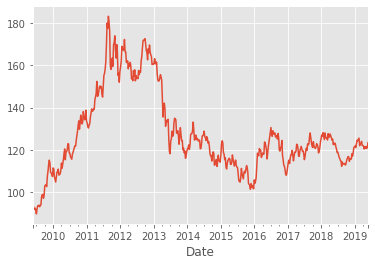

In [10]:
# Extracting the series
series = df['Close']
print(series.shape)
series.plot()

In [13]:
# Train Val Test Split
train_start = dt.date(2009,6,1)
train_end = dt.date(2014,5,31)
train_data = series.loc[train_start:train_end].values.reshape(-1,1)

val_start = dt.date(2014,6,1)
val_end = dt.date(2015,5,31)
val_data = series.loc[val_start:val_end].values.reshape(-1,1)

test_start = dt.date(2016,6,1)
test_end = dt.date(2019,6,1)
test_data = series.loc[test_start:test_end].values.reshape(-1,1)

print(train_data.shape,val_data.shape,test_data.shape)

(261, 1) (52, 1) (156, 1)


In [14]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(261, 1) (52, 1) (156, 1)


In [29]:
timesteps = 10
hl = [10,6]
lr = 1e-3
batch_size = 64
num_epochs = 100

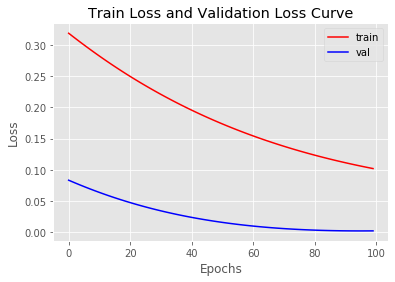

In [30]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

In [31]:
rmse, r2_value,true,predicted = evaluate_model(model,test,10)
print('RMSE = {}'.format(rmse))
print('MSE = {}'.format(rmse*rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

ValueError: too many values to unpack (expected 4)

In [17]:
# Save a model
model.save('UV-LSTM_40_[40,35]_1e-3_64.h5')
del model
# Load a model
#model = load_model('UV-LSTM_40_[40,35]_1e-3_64.h5')

## Cross-Validation

In [5]:
# Hyperparameters
timesteps = 40
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 50

In [7]:
# Extracting the series
series = df['Close'].values.reshape(-1,1)
print(series.shape)

(5670, 1)


In [8]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[0.5505618 ],
       [0.5505618 ],
       [0.54606742],
       ...,
       [0.91406745],
       [0.93204498],
       [0.92737079]])

### Split I

In [20]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[4*split_size:5*split_size]

Split 1
MSE = 0.0010880572767893299
RMSE = 0.03298571322238356
R-Squared Score = 0.7377708710940254


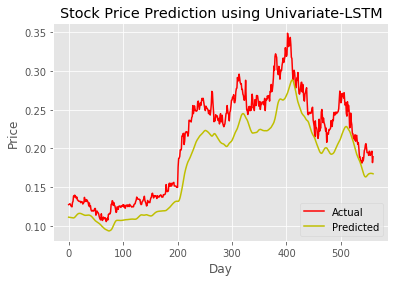

In [26]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,timesteps,hl,lr,batch_size,num_epochs)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.save("UV-LSTM-Split1.h5")

### Split II

Split 2
MSE = 0.00022881760950405595
RMSE = 0.015126718398385551
R-Squared Score = 0.9448534156256428


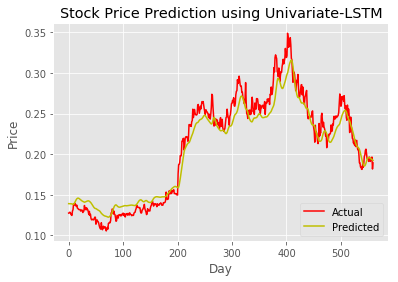

In [32]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history['loss']
val_loss["Split2"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split2.h5")

### Split III

Split 3
MSE = 0.00011030587113307203
RMSE = 0.010502660193164016
R-Squared Score = 0.9264717226530703


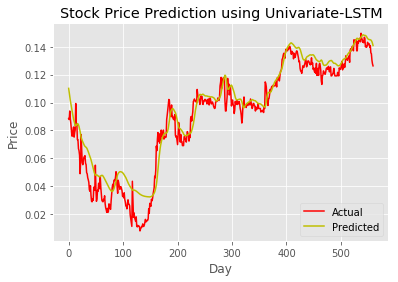

In [36]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history['loss']
val_loss["Split3"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split3.h5")

### Split IV

Split 4
MSE = 0.00023205697524958073
RMSE = 0.015233416401109133
R-Squared Score = 0.9884052121714179


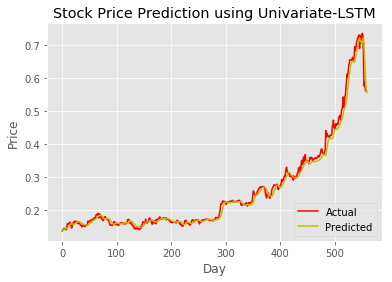

In [38]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history['loss']
val_loss["Split4"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split4.h5")

### Split V

Split 5
MSE = 0.0003562171895245122
RMSE = 0.0188737168974347
R-Squared Score = 0.9594568333556925


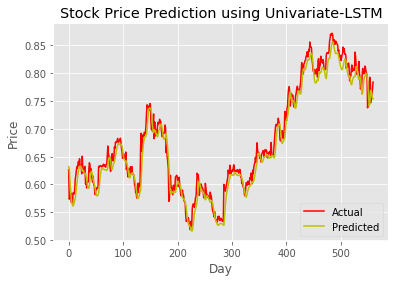

In [40]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history['loss']
val_loss["Split5"] = history.history['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.save("UV-LSTM-Split5.h5")

In [41]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.00040307959999999997
Avg. RMSE = 0.018544444799999997
Avg. R2-score = 0.911391611


In [42]:
CV_results.to_csv('UV-LSTM_CrossValidation.csv')
train_loss.to_csv('UV-LSTM_CrossValidation_TrainLoss.csv')
val_loss.to_csv('UV-LSTM_CrossValidation_ValLoss.csv')